In [220]:
# pandas/numpy imports
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Vector Autoregressive Model import
from statsmodels.tsa.vector_ar.var_model import VAR

In [221]:
# Get current directory
cwd = os.getcwd()

# Data Preparation

- Explore datasets and timeframes of analysis.
- Converge both datasets in order to proceed with multivariate time forecasting.
- For initial model, we will look at 'World' Entity and start from 1985 onwards.
- Data has already been resampled and is on year-by-year basis.
- CO2 emissions is on per capita basis.
- All datasets have been downloaded from the public organization, 'ourworldindata.org'.

In [222]:
df_co2 = pd.read_csv(os.path.join(cwd, "data", "annual-co2-emissions-per-country.csv"))
df_egen = pd.read_csv(os.path.join(cwd, "data", "electricity-prod-source-stacked.csv"))

In [223]:
df_co2.head()

,Entity,Code,Year,Annual CO₂ emissions
0,Afghanistan,AFG,1949,14656.0
1,Afghanistan,AFG,1950,84272.0
2,Afghanistan,AFG,1951,91600.0
3,Afghanistan,AFG,1952,91600.0
4,Afghanistan,AFG,1953,106256.0


In [224]:
df_egen.head()

,Entity,Code,Year,Other renewables excluding bioenergy - TWh (adapted for visualization of chart electricity-prod-source-stacked),Electricity from bioenergy - TWh (adapted for visualization of chart electricity-prod-source-stacked),Electricity from solar - TWh (adapted for visualization of chart electricity-prod-source-stacked),Electricity from wind - TWh (adapted for visualization of chart electricity-prod-source-stacked),Electricity from hydro - TWh (adapted for visualization of chart electricity-prod-source-stacked),Electricity from nuclear - TWh (adapted for visualization of chart electricity-prod-source-stacked),Electricity from oil - TWh (adapted for visualization of chart electricity-prod-source-stacked),Electricity from gas - TWh (adapted for visualization of chart electricity-prod-source-stacked),Electricity from coal - TWh (adapted for visualization of chart electricity-prod-source-stacked)
0,ASEAN (Ember),NaN,2000,16.93,5.87,0.0,0.0,50.45,0.0,65.07,164.26,76.03
1,ASEAN (Ember),NaN,2001,16.40,6.46,0.0,0.0,54.33,0.0,50.99,190.41,86.26
2,ASEAN (Ember),NaN,2002,16.61,6.62,0.0,0.0,53.29,0.0,54.32,208.92,93.43
3,ASEAN (Ember),NaN,2003,15.74,7.45,0.0,0.0,53.21,0.0,53.32,226.51,102.01
4,ASEAN (Ember),NaN,2004,16.57,8.40,0.0,0.0,52.99,0.0,59.43,244.16,115.01


In [225]:
# Filter Entity and Year > 1985, Fill NA
df1 = df_co2[(df_co2['Entity'] == 'World') & (df_co2['Year'] >= 1985)].reset_index(drop=True)
df1.columns = ['entity', 'code', 'year', 'annual_co2_emissions']
df2 = df_egen[df_egen['Entity'] == 'World'].fillna(0).reset_index(drop=True)
df2.columns = ['entity', 'code', 'year', 'other_renew', 'bio', 'solar', 'wind', 'hydro', \
               'nuclear', 'oil', 'gas', 'coal']
# Merge DFs
df = pd.merge(df1, df2, how='left', left_on=['entity', 'year'], right_on=['entity', 'year'])
df = df[['year', 'annual_co2_emissions', 'solar', 'wind', 'hydro', \
               'nuclear', 'oil', 'gas', 'coal']]
df = df.set_index('year')

array([<Axes: xlabel='year'>, <Axes: xlabel='year'>,
       <Axes: xlabel='year'>, <Axes: xlabel='year'>,
       <Axes: xlabel='year'>, <Axes: xlabel='year'>,
       <Axes: xlabel='year'>, <Axes: xlabel='year'>], dtype=object)

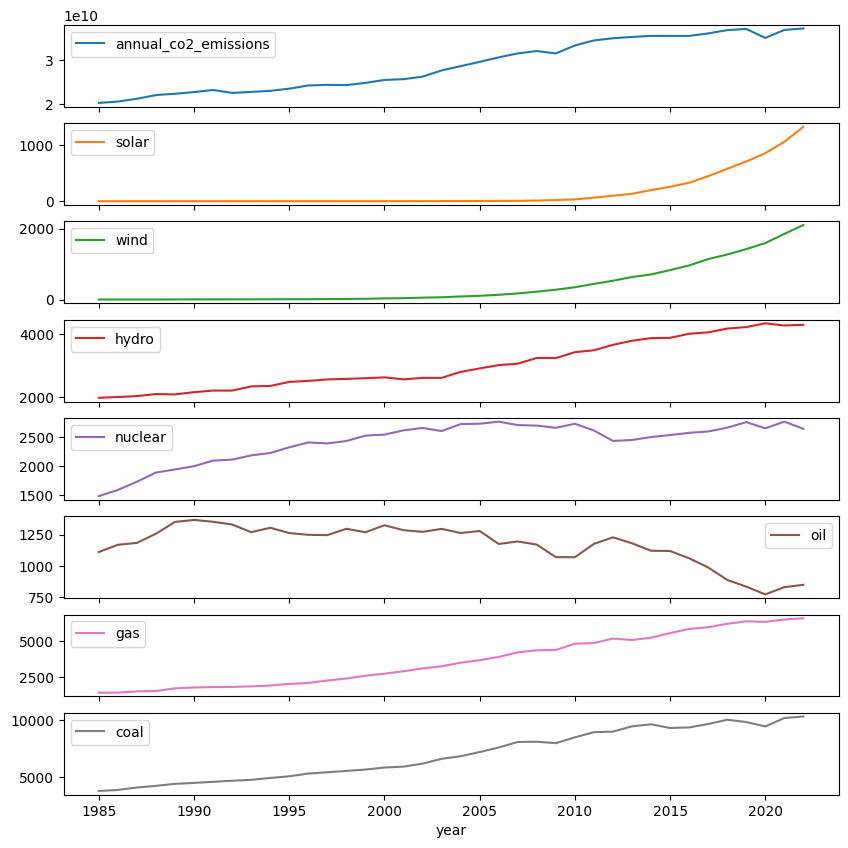

In [226]:
df.plot(subplots=True, sharex=True, figsize=(10,10))

### Exploration Takeaways: 
- It appears that World CO2 emissions have risen steadily from early 2000s till 2012 and has tapered off since.
- Solar and wind has risen almost exponentially since 2010.
- Hydro seems to have risen linearly since early 1990s since 2020 and has tapered off.
- Nuclear unfortunately seems to have also tapered off.
- Oil has had a steady decline since the 1990s. 
- Natural gas and coal have been on a steady rise since the 90s. Coal in particular seems to be the most popular source of electricity.

# Modeling using VAR models (Vector Autoregressive)

- We will use VAR to perform multivariate time-series forecasting. My initial choice was ARIMA, but unfortunately, it is more utilized for univariate forecasting.
- To force non-negative solutions, we will predict the logarithm of each variable. Then, after fitting and forecasting, we will then take the exponential of the solution.
- Our training set will involve data prior to 2018.
- Max lags of 1 must be selected based on limited number of observations compared to number of variables. This was validated utilizing statsmodels VAR.selectorder() function.

In [227]:
log_df = np.log(df)
train = log_df[log_df.index < 2018]
test = log_df[log_df.index >= 2018]

In [228]:
model = VAR(endog=train)

/Users/vishakhpillai/DS_Projects/ghg_forecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [229]:
# Lag order must be chosen for the number of observations and equations
model.select_order(1)

In [230]:
results = model.fit(maxlags=1, ic='aic')
prediction = results.forecast(model.endog, steps=len(test))
pred_df = pd.DataFrame(np.exp(prediction), columns=test.columns, index=test.index)

In [231]:
for i in test.columns.to_list():
    print('rmse value for', i, 'is : ', np.sqrt(mean_squared_error(pred_df[i], df[df.index >= 2018][i])))

rmse value for annual_co2_emissions is :  1794920826.563834
rmse value for solar is :  426.408527128274
rmse value for wind is :  501.3429251135122
rmse value for hydro is :  87.8021531732907
rmse value for nuclear is :  183.6766862377327
rmse value for oil is :  156.36752413059813
rmse value for gas is :  154.79178391490663
rmse value for coal is :  592.2891275288495


Text(0, 0.5, 'Prediction - Actual')

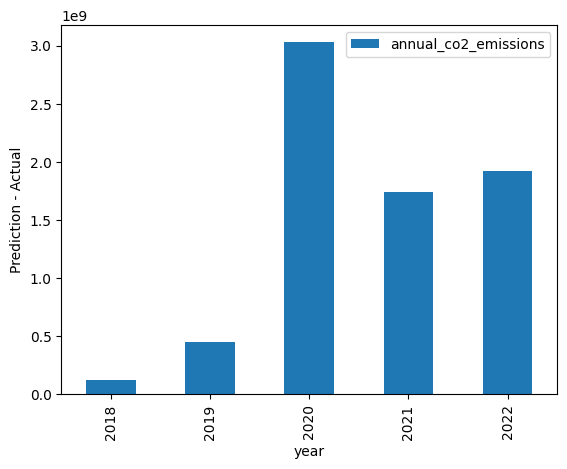

In [232]:
# Visualizing delta  
delta = pred_df - np.exp(test)
delta[['annual_co2_emissions']].plot.bar()
plt.ylabel('Prediction - Actual')

Text(0, 0.5, 'Prediction - Actual')

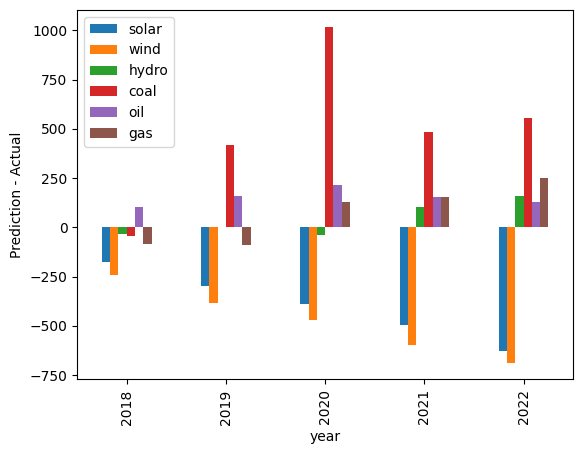

In [233]:
delta[['solar','wind','hydro','coal','oil','gas']].plot.bar()
plt.ylabel('Prediction - Actual')

### Modeling Takeaways
- It appears that the model is underpredicting renewable growth, which is directly correlating with an overprediction of CO2 emissions.
- Simultaneously the model also appears to be overpredicting oil/gas/coal growth, which is also contributing to the CO2 emission overprediction.
- The 3-year stagnation from 2020 to 2022 is highly likely due to the COVID-19 pandemic, which may also be driving the delta in the VAR model.

# Forecasting Emissions to 2050
- Now, we will insert all data from 1985 to 2022 and have the model forecast until 2050.

In [256]:
model = VAR(endog=log_df)
model_fit = model.fit(maxlags=1)
yhat = model_fit.forecast(model.endog, steps=28)

/Users/vishakhpillai/DS_Projects/ghg_forecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [257]:
future_time = [2023 + i*1 for i in range(0,28)]
yhat_df= pd.DataFrame(np.exp(yhat), columns=test.columns, index=future_time)

Text(0, 0.5, 'Annual CO2 Emissions (tons)')

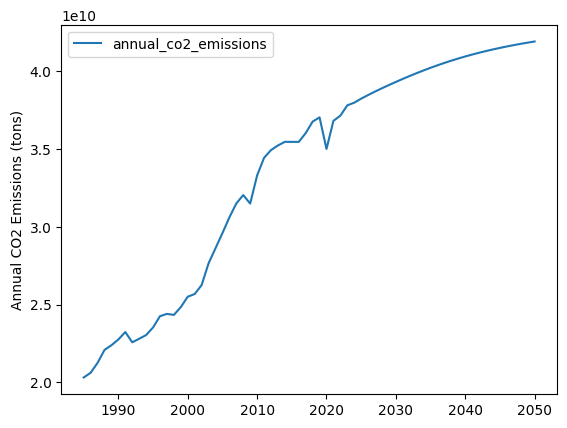

In [258]:
future_co2 = yhat_df[['annual_co2_emissions']]
past_future_co2 = pd.concat([df[['annual_co2_emissions']],yhat_df[['annual_co2_emissions']]])
past_future_co2.plot()
plt.ylabel('Annual CO2 Emissions (tons)')

Text(0, 0.5, 'Global Electricity Mix (%)')

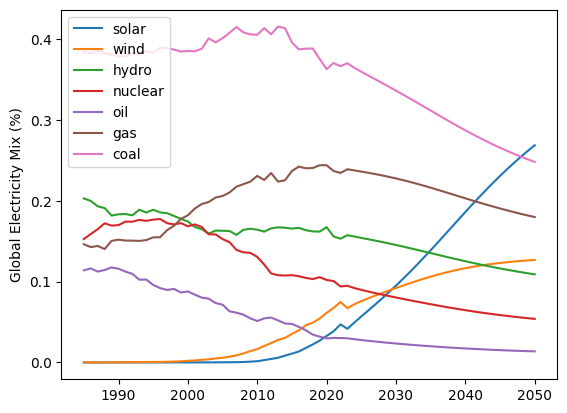

In [259]:
future_egen = yhat_df[['solar','wind','hydro','nuclear','oil','gas','coal']]
past_future_egen = pd.concat([df[['solar','wind','hydro','nuclear','oil','gas','coal']], future_egen])
past_future_egen.div(past_future_egen.sum(axis=1), axis=0).plot()
plt.ylabel('Global Electricity Mix (%)')

Text(0, 0.5, 'Global Electricity Usage (TWh)')

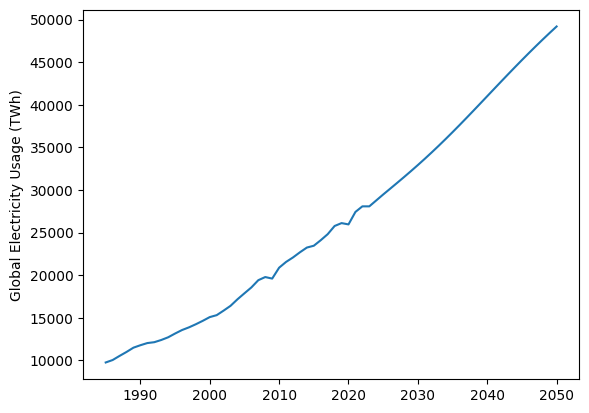

In [251]:
pd.concat([df[['solar','wind','hydro','nuclear','oil','gas','coal']].sum(axis=1), future_egen.sum(axis=1)]).plot()
plt.ylabel('Global Electricity Usage (TWh)')

### Forecasting Takeaways
- Since we are including data from 2018 to 2022, the model is now more biased to predict a generous growth of renewables with a tapering of annual co2 emissions.
- Although wind is outpacing solar into 2023, the model interestingly predicts solar to accelerate from 2030 to 2040 at a nearly linear growth, while wind grows sublinearly.
- The model forecasts that around 2048, solar will outpace coal as the world's primary source of electricity production.
- Global electricity usage is predicted to double from 2020 to 2050 to around 50,000 TWh. This is reasonable due to the global population increase, though as conjecture, it may also be due to the growth of developing nations.
- Developing countries will grow through infrastructure expansion, which will certainly require greater electricity usage.